In [11]:
import pandas as pd
import numpy as np
import spacy

dataset_path = "DataSet/1/dataset_1.csv"
df = pd.read_csv(dataset_path)

In [12]:
df.describe()

,id,taxon.id,taxon.rank_level
count,8.507300e+04,8.507300e+04,85073.0
mean,1.452446e+08,1.667973e+05,10.0
std,7.183329e+07,1.691351e+05,0.0
min,7.918000e+03,5.216000e+04,10.0
25%,8.532996e+07,5.248800e+04,10.0
50%,1.594725e+08,6.919000e+04,10.0
75%,2.170463e+08,3.246370e+05,10.0
max,2.533464e+08,1.393592e+06,10.0


In [13]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Column: {column}")
    print(f"Unique values: {unique_values[:20]}")  # Displaying only the first 10 unique values for brevity
    print(f"Total unique values: {len(unique_values)}\n")

Column: id
Unique values: [  7918  23923 188235 294726 299015 322683 345187 346407 346434 346448
 346451 355503 363410 377184 377186 377188 377189 391317 411249 413867]
Total unique values: 85073

Column: species_guess
Unique values: ['long hoverfly' 'volucella pellucens' 'american thintail fly'
 'dangling swamp-lover' 'sericomyia silentis' 'marmalade hoverfly'
 'meliscaeva auricollis' 'thick-legged hoverfly' 'stripe-winged drone fly'
 'eristalis intricaria' 'leucozona glaucia' 'blaue breitbandschwebfliege'
 'long hover fly' 'tapered dronefly' 'chrysogaster solstitialis'
 'leucozona laternaria' 'cheilosia illustrata' 'trivittate sunfly'
 'sunfly' 'european hoverfly']
Total unique values: 636

Column: time_observed_at
Unique values: [nan '2013-07-06T15:53:53+01:00' '2013-07-24T01:35:25+01:00'
 '2013-07-26T11:42:17+01:00' '2013-07-26T10:57:12+01:00'
 '2013-07-26T11:22:01+01:00' '2013-07-26T10:53:01+01:00'
 '2013-08-01T12:17:59+01:00' '2013-08-10T13:48:01+01:00'
 '2013-08-25T16:33:54+01:0

In [14]:
df["species_guess"].value_counts()

species_guess
marmalade hover fly          7797
tapered drone fly            7739
common drone fly             5708
sun fly                      5102
hornet mimic hover fly       3522
                             ... 
almindelig marksvirreflue       1
srutinė žiedmusė                1
광붙이꽃등에                          1
mosca-zângão europeia           1
long-tailed aphideater          1
Name: count, Length: 636, dtype: int64

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from fuzzywuzzy import fuzz
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_lg")

In [21]:
def normalize_text(text):
    return text.lower().strip()

# Function to compute text similarity matrix
def compute_similarity_matrix(texts):
    docs = nlp.pipe(texts)
    vectors = np.array([doc.vector for doc in docs])

    norms = np.linalg.norm(vectors, axis=1)
    zero_norm_indices = np.where(norms == 0)[0]

    if len(zero_norm_indices) > 0:
        vectors[zero_norm_indices] = (
            np.random.rand(len(zero_norm_indices), vectors.shape[1]) * 1e-6
        )

    norms = np.linalg.norm(vectors, axis=1)
    vectors = vectors / norms[:, np.newaxis]

    similarity_matrix = cosine_similarity(vectors)
    return similarity_matrix


# Function to compute fuzzy similarity matrix
def compute_fuzzy_similarity_matrix(texts):
    n = len(texts)
    similarity_matrix = np.zeros((n, n))

    def compute_similarity(i, j):
        if i != j:
            return fuzz.ratio(texts[i], texts[j]) / 100.0
        else:
            return 1.0

    results = Parallel(n_jobs=-1)(
        delayed(compute_similarity)(i, j) for i in range(n) for j in range(n)
    )
    similarity_matrix = np.array(results).reshape(n, n)
    return similarity_matrix

In [22]:
df["species_guess"] = df["species_guess"].apply(normalize_text)
texts = df["species_guess"][0:20]
print("texts: ", texts)

texts:  0                   long hoverfly
1             volucella pellucens
2           american thintail fly
3            dangling swamp-lover
4            dangling swamp-lover
5             sericomyia silentis
6              marmalade hoverfly
7              marmalade hoverfly
8           meliscaeva auricollis
9           thick-legged hoverfly
10        stripe-winged drone fly
11            sericomyia silentis
12           eristalis intricaria
13            sericomyia silentis
14             marmalade hoverfly
15              leucozona glaucia
16    blaue breitbandschwebfliege
17                 long hover fly
18               tapered dronefly
19      chrysogaster solstitialis
Name: species_guess, dtype: object


In [23]:
similarity_matrix = compute_similarity_matrix(texts)
np.fill_diagonal(similarity_matrix, 1)

# Convert similarity matrix to distance matrix
distance_matrix = 1 - pd.DataFrame(similarity_matrix)

# Clustering using dbscan
dbscan = DBSCAN(eps=0.15, min_samples=1, metric="precomputed")
clusters = dbscan.fit_predict(distance_matrix)
print(clusters)

[ 0  1  2  3  3  4  5  5  6  7  8  9 10 11  5 12 13 14 15 16]


[ 0  1  2  3  3  4  5  5  6  7  8  4  9  4  5 10 11  0 12 13]


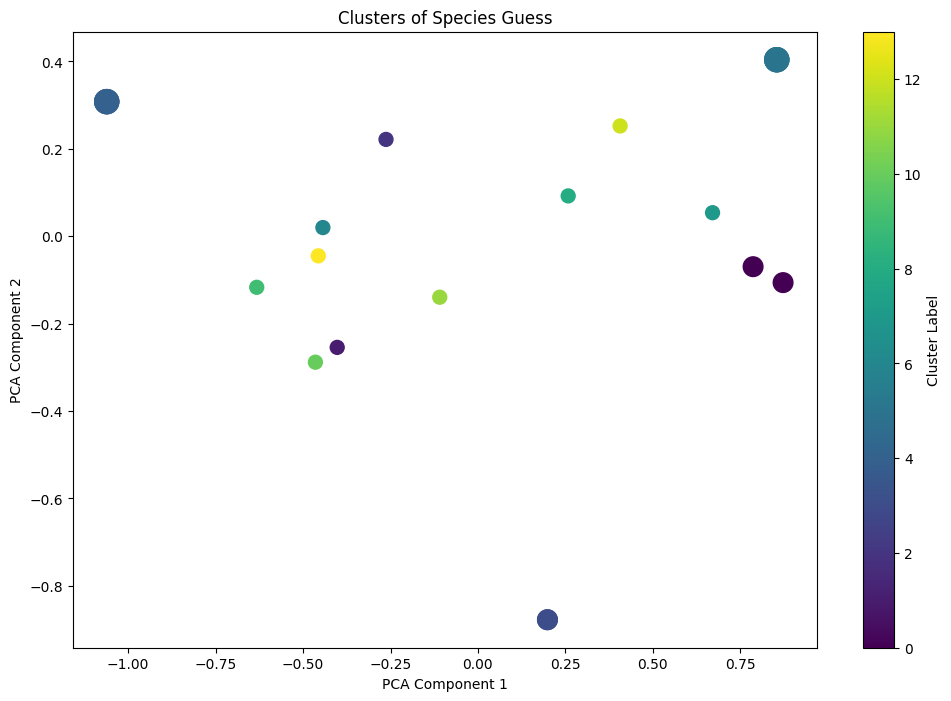

In [24]:
similarity_matrix = compute_fuzzy_similarity_matrix(texts)

# Convert similarity matrix to distance matrix
distance_matrix = 1 - similarity_matrix
dbscan = DBSCAN(eps=0.1, min_samples=1, metric="precomputed")
clusters = dbscan.fit_predict(distance_matrix)
print(clusters)

cluster_counts = np.bincount(clusters + 1)  # Add 1 to handle -1 (noise) cluster
sizes = cluster_counts[clusters + 1] * 100

# Plotting the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(distance_matrix)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap="viridis", s=sizes
)
plt.title("Clusters of Species Guess")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster Label")

plt.show()

In [25]:
# Labels
species = df[df["taxon.rank"] == "species"]["taxon.name"]
print(species.value_counts())
species.shape

taxon.name
episyrphus balteatus      9895
eristalis pertinax        8299
eristalis tenax           6805
helophilus pendulus       6142
myathropa florea          5703
                          ... 
pipizella maculipennis       1
pipizella virens             1
microdon devius              1
melangyna arctica            1
eupeodes americanus          1
Name: count, Length: 200, dtype: int64


(85073,)

In [36]:
from sklearn.preprocessing import OneHotEncoder
species_vals = species.unique()

onehot_encoder = OneHotEncoder()
onehot_labels = onehot_encoder.fit_transform(species_vals.reshape(-1, 1))
species_to_onehot = {
    species: onehot_labels[i] for i, species in enumerate(species_vals)
}
print("first encoded label: ", species_to_onehot[species_vals[0]])
print("sum: ", species_to_onehot[species_vals[0]].sum())

df['enocded_lables'] = df['taxon.name'].apply(lambda x: species_to_onehot[x])
df['enocded_lables']

first encoded label:  <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 200)>
  Coords	Values
  (0, 175)	1.0
sum:  1.0


0        <Compressed Sparse Row sparse matrix of dtype ...
1        <Compressed Sparse Row sparse matrix of dtype ...
2        <Compressed Sparse Row sparse matrix of dtype ...
3        <Compressed Sparse Row sparse matrix of dtype ...
4        <Compressed Sparse Row sparse matrix of dtype ...
                               ...                        
85068    <Compressed Sparse Row sparse matrix of dtype ...
85069    <Compressed Sparse Row sparse matrix of dtype ...
85070    <Compressed Sparse Row sparse matrix of dtype ...
85071    <Compressed Sparse Row sparse matrix of dtype ...
85072    <Compressed Sparse Row sparse matrix of dtype ...
Name: enocded_lables, Length: 85073, dtype: object